In [1]:
%reset -f
%load_ext autoreload
%autoreload 2
#matplotlib figure size
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
from mri_project.custom_imports import *
from mri_project.utility import dfe
__spec__ = 'Mardas'

In [2]:
identifier = "ea132"
root = "../data/data/images_with_predictions_v05"
files = glob.glob(root+"/*data")
file = np.random.choice(files)

In [3]:
rm -r $root/mri_analysis_behnam_$identifier

rm: cannot remove '../data/data/images_with_predictions_v05/mri_analysis_behnam_ea132': No such file or directory


In [4]:
def get_write_dir(id_):
    id_ = id_.replace('../data/mri_analysis', f'/mri_analysis_behnam_{identifier}')\
        .replace(" Set#", '/Set').replace(' ', '__').replace(':', "_")\
        .replace('..', 'blahblah').replace('.', '_').replace('blahblah', '..')
    d, f, e = dfe(id_)
    return root+d, f, e

In [5]:
import scipy.ndimage
import imageio

In [21]:
from uuid import uuid4
predicted = []
traced = []
def rescale(x):
    return np.uint8((x-x.min())/(x.max()-x.min())*255)
def map_fun(file, index=-1):
    # print(index, file)
    # if index % 40 == 0:
    #     print(f"{index}:{file}")
    data = joblib.load(file)
    data.predicted = data.predicted_postprocessed
    data.get_traced_contours(90)
    data.get_predicted_contours(90)
    data.get_contour_areas()
    data.get_contour_centers() 
    dic = {
        'raw': data.raw_image,
        'traced': data.traced_image,
        'predicted': data.predicted,
        'traced_lever_arms_90': data.traced_lever_arm_images[90]+150,
        'predicted_lever_arms_90': data.predicted_lever_arm_images[90]+150,
    }
    dr, f, e = get_write_dir(data.id)
    if not os.path.exists(dr):
        os.makedirs(dr)
    for k, v in dic.items():
        # plt.imshow(v)
        # plt.axis('off')
        # plt.savefig(f"{dr}/{k}.png", dpi=150, bbox_inches=0)
        f_name = f"{dr}/{k}_{f}.png"
        # print(f_name)
        v2 = rescale(v)
        print(v2.shape)
        imageio.imsave(f_name, v2)
    plt.imshow(v2)
    return data.id, {'has_good_prediction': data.has_good_prediction(), 
                     'traced': data.traced_features, 'predicted': data.predicted_features
                    }

0 ../data/data/images_with_predictions_v05/1-CO5-3_16RepPreRaw.data
(1404, 1404, 3)
(1400, 1400, 3)
(1404, 1404)
(1404, 1404)
(1404, 1404)


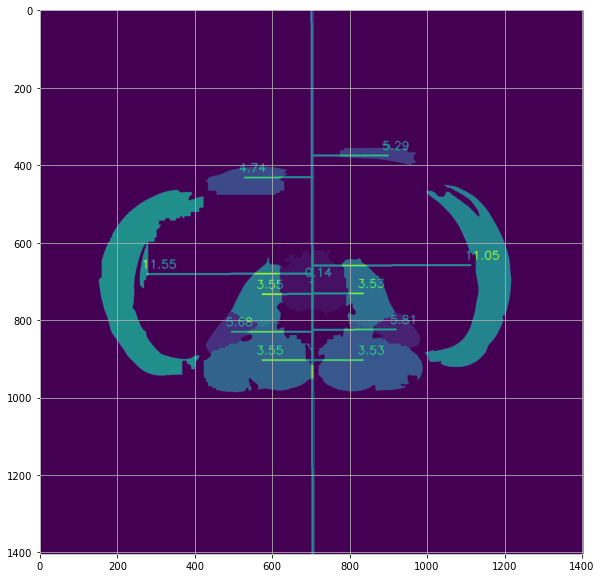

In [22]:
for index, file in enumerate(files):
    if index % 40 == 0:
        print(index, file)
    map_fun(file)
    break

In [23]:
import dask.bag as db

In [24]:
res = db.from_sequence(files).map(map_fun).compute()

In [25]:
from flatten_dict import flatten

In [26]:
res_fl = flatten(dict(res))

In [53]:
df = pd.DataFrame(res_fl)
df = df.transpose().reset_index()
df['value'] = df[0].combine(df[1], lambda x, y: x if x == y else (x, y))
df = df.drop([0, 1], axis=1)
df.columns = ['id', 'type', 'metric', 'muscle', 'value']

In [54]:
df.head(20)

,id,type,metric,muscle,value
0,../data/mri_analysis/2.Multigroup Set#2/Contro...,has_good_prediction,NaN,NaN,True
1,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,1.0,0.39448
2,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,4.0,3.73311
3,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,5.0,2.6059
4,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,6.0,1.96799
5,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,7.0,2.78732
6,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,8.0,4.88394
7,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,9.0,5.16631
8,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,10.0,10.1741
9,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,11.0,9.80511


In [55]:
df.to_csv(root+"/all_features_3bd0c.csv", index=False)

In [56]:
df_piv = df.pivot(index=['id', 'muscle'], columns=['type', 'metric'])['value'].reset_index()
df_piv.to_csv(root+"all_features_pivot_3bd0c.csv", index=False)

In [57]:
df_piv.sort_values(['id', 'muscle'])

type                                                   id muscle  \
metric                                                             
1       ../data/mri_analysis/1.Multigroup Set#1_DONE/C...    1.0   
2       ../data/mri_analysis/1.Multigroup Set#1_DONE/C...    2.0   
3       ../data/mri_analysis/1.Multigroup Set#1_DONE/C...    3.0   
4       ../data/mri_analysis/1.Multigroup Set#1_DONE/C...    4.0   
5       ../data/mri_analysis/1.Multigroup Set#1_DONE/C...    5.0   
...                                                   ...    ...   
9364    ../data/mri_analysis/4.Contiguous Set#2/Weight...    8.0   
9365    ../data/mri_analysis/4.Contiguous Set#2/Weight...    9.0   
9366    ../data/mri_analysis/4.Contiguous Set#2/Weight...   10.0   
9367    ../data/mri_analysis/4.Contiguous Set#2/Weight...   11.0   
9356    ../data/mri_analysis/4.Contiguous Set#2/Weight...    NaN   

type   has_good_prediction       traced           \
metric                 NaN lever_arm_90     area   
1                      NaN      10.7449  29.8948   
2                      NaN      11.0955  29.7537   
3                      NaN      3.94039  26.8763   
4                      NaN       4.5469   26.631   
5                      NaN     0.146411   12.317   
...                    ...          ...      ...   
9364                   NaN      3.64851  5.50711   
9365                   NaN      2.67386  4.50121   
9366                   NaN      10.7578  17.4392   
9367                   NaN      11.2935  16.6216   
9356                  True          NaN      NaN   

type                                               predicted           \
metric                                   center lever_arm_90     area   
1        (1095.6448087431695, 629.311475409836)     0.106978  14.5728   
2         (289.787323943662, 660.1408450704225)      5.94471  5.66168   
3               (554.2135416666666, 890.984375)      6.09629  5.43731   
4         (867.420202020202, 905.5414141414142)      4.14985   8.4356   
5        (704.6863753213368, 701.8071979434447)      4.71089  8.80135   
...                                         ...          ...      ...   
9364    (1162.9712460063897, 817.3450479233227)      3.43313  6.30511   
9365      (834.8545034642033, 825.635103926097)      2.53818  5.51101   
9366    (1531.6973451327433, 675.7619469026548)      9.93164  19.5004   
9367     (387.2413101604278, 681.4110962566845)      10.9872  27.9463   
9356                                        NaN          NaN      NaN   

type                                             
metric                                   center  
1        (713.8634920634921, 706.1746031746031)  
2        (929.4948979591836, 831.4897959183673)  
3        (485.1447963800905, 810.5610859728507)  
4        (862.5828877005348, 441.0534759358289)  
5        (535.6304985337243, 446.3284457478006)  
...                                         ...  
9364     (1160.5714285714287, 831.478021978022)  
9365     (850.6019184652279, 798.1798561151079)  
9366    (1497.5665188470066, 671.9944567627495)  
9367     (411.9781659388646, 729.4872114784779)  
9356                                        NaN  

[9368 rows x 9 columns]